# Data Filtration Statistics Report

This notebook generates a comprehensive report on how different particle count and kinematic cut configurations affect data filtering.

**Important:** This notebook fetches **UNFILTERED** data directly from ATLAS Open Data remotely to ensure accurate filtering statistics. Local files are not used as they may already be filtered from previous runs.

**Analysis includes:**
1. Particle count filtering statistics (min/max for Electrons, Muons, Jets, Photons)
2. Kinematic cut filtering statistics (pt, eta, phi min/max)
3. Combined filtering effects
4. Event retention rates
5. Distribution analysis
6. Recommendations for optimal filter settings


In [ ]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak
from pathlib import Path
import yaml
from itertools import product

from src.parse_atlas import parser
from src.im_calculator.im_calculator import IMCalculator

%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 8)


In [ ]:
# Configuration
config_path = "../configs/pipeline_config.yaml"

# Load config to get release years
with open(config_path) as f:
    config = yaml.safe_load(f)

# Get release years from config (use a subset for testing if needed)
release_years = config.get("parsing_config", {}).get("atlasparser_config", {}).get("release_years", ["2024r-pp"])
print(f"Release years to fetch: {release_years}")

# Fetch remote file URIs (unfiltered data from ATLAS Open Data)
print("\nFetching remote file URIs from ATLAS Open Data...")
release_years_file_ids = parser.AtlasOpenParser.fetch_record_ids_for_release_years(
    release_years, 
    timeout=120
)

# Count total files that will be analyzed
total_sample_files = sum(min(2, len(file_uris)) for file_uris in release_years_file_ids.values())
for release_year, file_uris in release_years_file_ids.items():
    num_files = min(2, len(file_uris))  # Use 2 files per release year
    print(f"  {release_year}: {len(file_uris)} files available, using {num_files} for analysis")

print(f"\nTotal sample files to analyze: {total_sample_files}")
print("Note: These are remote URIs - data will be fetched directly from ATLAS Open Data (unfiltered)")


Found 5 ROOT files, using 3 for analysis
Sample files: ['2024r-hi_mc_3f31b3fbd2e26f17.root', '2024r-hi_9c66f70769ba4409.root', '2024r-hi_f47176be14303032.root']


In [ ]:
# Load and combine sample files from remote URIs
all_events = None

# Process each release year's sample files
for release_year, file_uris in release_years_file_ids.items():
    # Get sample files for this release year (first 2)
    sample_uris_for_year = file_uris[:min(2, len(file_uris))]
    
    for file_uri in sample_uris_for_year:
        print(f"Loading remote file...")
        print(f"  URI: {file_uri[:80]}..." if len(file_uri) > 80 else f"  URI: {file_uri}")
        print(f"  Release year: {release_year}")
        
        # Parse the remote file directly (parse_root_file handles URIs)
        try:
            particle_arrays = parser.AtlasOpenParser.parse_root_file(
                file_uri,  # Can be a URI or local path
                batch_size=None,  # Process entire file
                release_year=release_year,
                temp_directory=None  # Use system temp for compressed files
            )
            
            if particle_arrays is None or len(particle_arrays) == 0:
                print(f"  Warning: File is empty or could not be parsed")
                continue
            
            print(f"  ✓ Loaded {len(particle_arrays):,} events")
            
            # Combine with previous events
            if all_events is None:
                all_events = particle_arrays
            else:
                all_events = ak.concatenate([all_events, particle_arrays])
                
        except Exception as e:
            print(f"  ✗ Error loading file: {e}")
            import traceback
            traceback.print_exc()
            continue

if all_events is None or len(all_events) == 0:
    print("\nERROR: No events loaded! Check network connection and file URIs.")
else:
    print(f"\n✓ Total events loaded: {len(all_events):,}")
    print(f"Available particle types: {all_events.fields}")
    
    # Show initial particle counts
    calculator = IMCalculator(all_events)
    print("\nInitial particle count statistics (UNFILTERED DATA):")
    for particle_type in all_events.fields:
        count = ak.num(all_events[particle_type])
        print(f"  {particle_type}: min={ak.min(count)}, max={ak.max(count)}, mean={ak.mean(count):.2f}, total={ak.sum(count):,}")


Loading 2024r-hi_mc_3f31b3fbd2e26f17.root...
  Release year: 2024r-hi
  Loaded 36,113 events
Loading 2024r-hi_9c66f70769ba4409.root...
  Release year: 2024r-hi
  Loaded 7,705,682 events
Loading 2024r-hi_f47176be14303032.root...
  Release year: 2024r-hi
  Loaded 8,735,163 events

✓ Total events loaded: 16,476,958
Available particle types: ['Muons']

Initial particle count statistics:
  Muons: min=1, max=6, mean=2.41, total=39,781,408


## Part 1: Particle Count Filtering Analysis

Test different particle count configurations and measure event retention rates.


In [ ]:
# Define test configurations for particle counts
# Test different min/max combinations for each particle type

particle_count_configs = [
    # Baseline: current config
    {
        "name": "Baseline (Current)",
        "Electrons": {"min": 1, "max": 6},
        "Muons": {"min": 1, "max": 6},
        "Jets": {"min": 0, "max": 8},
        "Photons": {"min": 0, "max": 5}
    },
    # Stricter: require more particles
    {
        "name": "Strict (High Counts)",
        "Electrons": {"min": 2, "max": 6},
        "Muons": {"min": 2, "max": 6},
        "Jets": {"min": 2, "max": 8},
        "Photons": {"min": 1, "max": 5}
    },
    # Lenient: allow fewer particles
    {
        "name": "Lenient (Low Counts)",
        "Electrons": {"min": 0, "max": 10},
        "Muons": {"min": 0, "max": 10},
        "Jets": {"min": 0, "max": 10},
        "Photons": {"min": 0, "max": 10}
    },
    # Focus on leptons
    {
        "name": "Lepton Focus",
        "Electrons": {"min": 1, "max": 8},
        "Muons": {"min": 1, "max": 8},
        "Jets": {"min": 0, "max": 4},
        "Photons": {"min": 0, "max": 3}
    },
    # Focus on jets
    {
        "name": "Jet Focus",
        "Electrons": {"min": 0, "max": 4},
        "Muons": {"min": 0, "max": 4},
        "Jets": {"min": 2, "max": 10},
        "Photons": {"min": 0, "max": 3}
    },
    # Very strict: high quality events
    {
        "name": "Very Strict",
        "Electrons": {"min": 2, "max": 4},
        "Muons": {"min": 2, "max": 4},
        "Jets": {"min": 2, "max": 6},
        "Photons": {"min": 0, "max": 3}
    }
]

print(f"Testing {len(particle_count_configs)} particle count configurations...")


Testing 6 particle count configurations...


In [ ]:
# Test each particle count configuration
particle_count_results = []

if all_events is not None:
    calculator = IMCalculator(all_events)
    initial_count = len(all_events)
    
    for config in particle_count_configs:
        # Convert config format to filter format
        particle_counts = {
            "Electrons": config["Electrons"],
            "Muons": config["Muons"],
            "Jets": config["Jets"],
            "Photons": config["Photons"]
        }
        
        # Apply filter
        filtered = calculator.filter_by_particle_counts(
            events=all_events,
            particle_counts=particle_counts,
            is_exact_count=False,
            is_particle_counts_range=True
        )
        
        filtered_count = len(filtered)
        retention_rate = (filtered_count / initial_count * 100) if initial_count > 0 else 0
        
        # Get particle count statistics for filtered events
        filtered_stats = {}
        for particle_type in all_events.fields:
            if particle_type in filtered.fields:
                count = ak.num(filtered[particle_type])
                filtered_stats[particle_type] = {
                    "min": int(ak.min(count)),
                    "max": int(ak.max(count)),
                    "mean": float(ak.mean(count)),
                    "total": int(ak.sum(count))
                }
        
        result = {
            "config_name": config["name"],
            "initial_events": initial_count,
            "filtered_events": filtered_count,
            "retention_rate": retention_rate,
            "filtered_out": initial_count - filtered_count,
            **filtered_stats
        }
        
        particle_count_results.append(result)
        
        print(f"{config['name']}: {filtered_count:,} / {initial_count:,} events ({retention_rate:.2f}% retained)")

# Create DataFrame
particle_count_df = pd.DataFrame(particle_count_results)
print("\n=== Particle Count Filtering Results ===")
print(particle_count_df[['config_name', 'initial_events', 'filtered_events', 'retention_rate']].to_string(index=False))


Baseline (Current): 16,476,958 / 16,476,958 events (100.00% retained)
Strict (High Counts): 9,901,138 / 16,476,958 events (60.09% retained)
Lenient (Low Counts): 16,476,958 / 16,476,958 events (100.00% retained)
Lepton Focus: 16,476,958 / 16,476,958 events (100.00% retained)
Jet Focus: 14,271,964 / 16,476,958 events (86.62% retained)
Very Strict: 7,696,144 / 16,476,958 events (46.71% retained)

=== Particle Count Filtering Results ===
         config_name  initial_events  filtered_events  retention_rate
  Baseline (Current)        16476958         16476958      100.000000
Strict (High Counts)        16476958          9901138       60.090813
Lenient (Low Counts)        16476958         16476958      100.000000
        Lepton Focus        16476958         16476958      100.000000
           Jet Focus        16476958         14271964       86.617712
         Very Strict        16476958          7696144       46.708525


/tmp/ipykernel_558881/1518100580.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(particle_count_df['config_name'], rotation=45, ha='right')


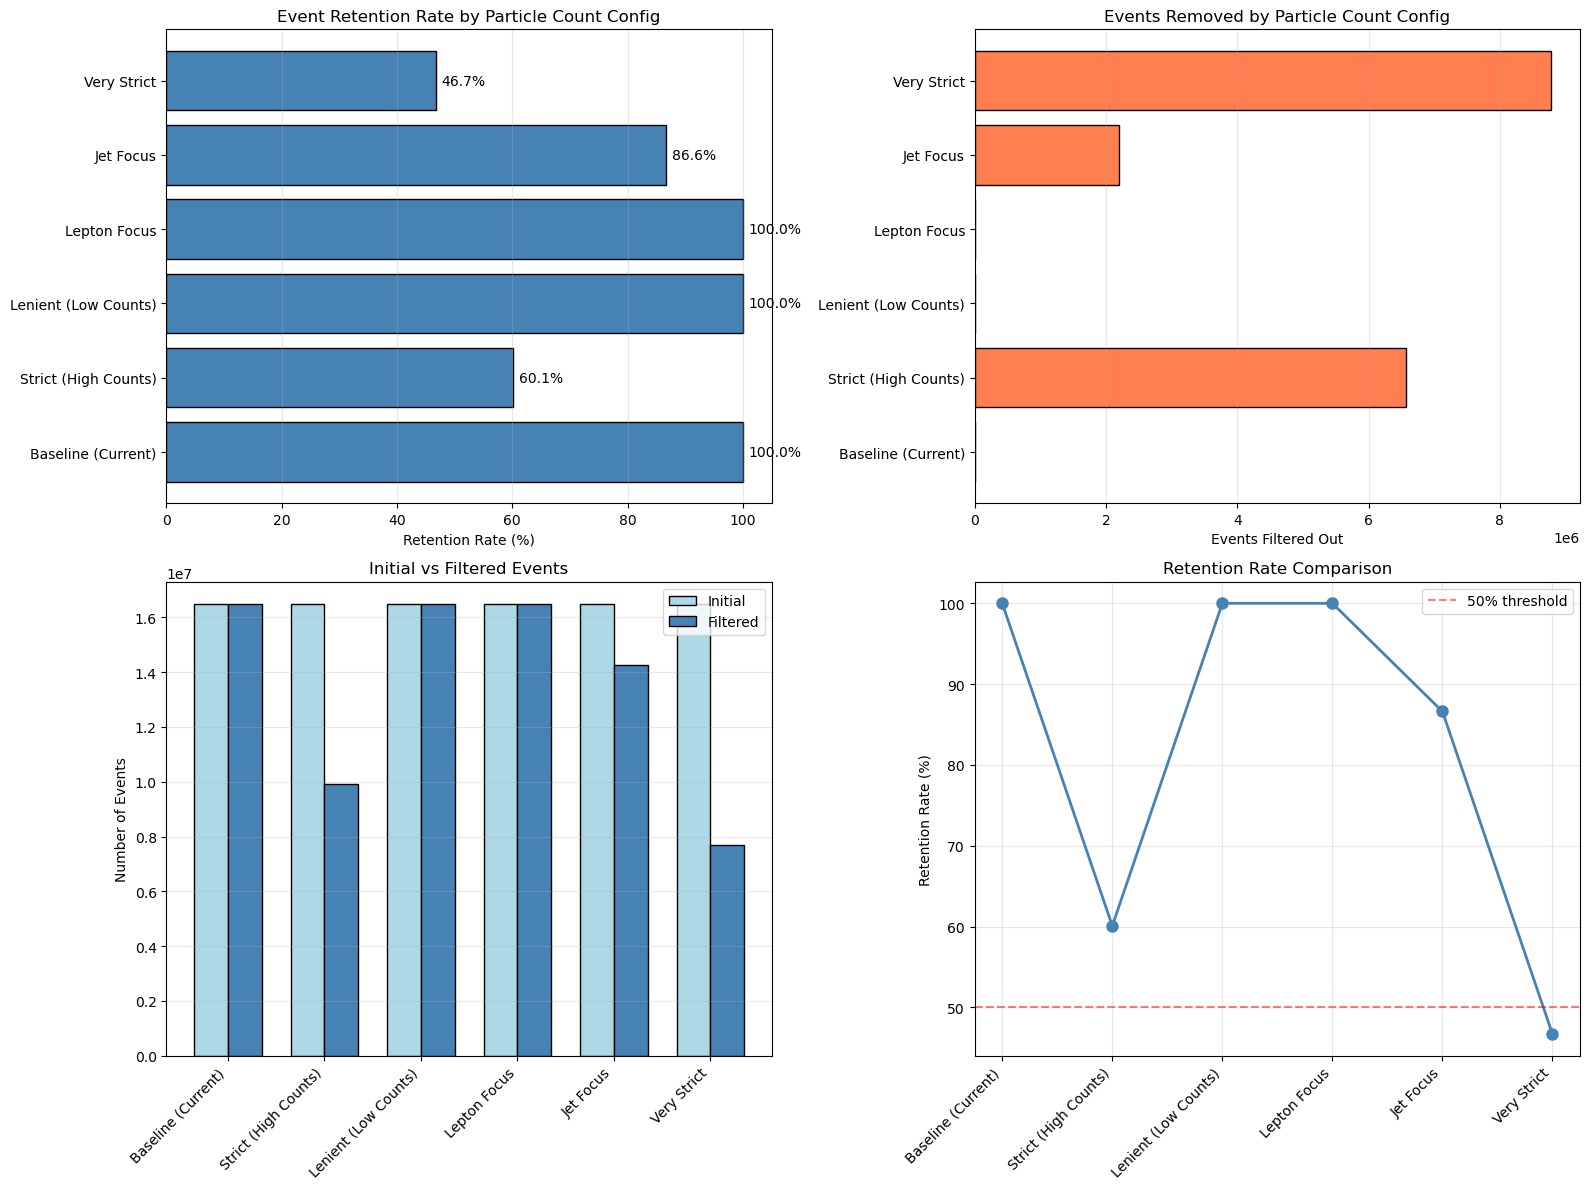

In [ ]:
# Visualize particle count filtering results
if len(particle_count_results) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Retention rate bar chart
    axes[0, 0].barh(range(len(particle_count_df)), particle_count_df['retention_rate'], 
                     color='steelblue', edgecolor='black')
    axes[0, 0].set_yticks(range(len(particle_count_df)))
    axes[0, 0].set_yticklabels(particle_count_df['config_name'])
    axes[0, 0].set_xlabel('Retention Rate (%)')
    axes[0, 0].set_title('Event Retention Rate by Particle Count Config')
    axes[0, 0].grid(True, alpha=0.3, axis='x')
    for i, v in enumerate(particle_count_df['retention_rate']):
        axes[0, 0].text(v + 1, i, f'{v:.1f}%', va='center')
    
    # Events filtered out
    axes[0, 1].barh(range(len(particle_count_df)), particle_count_df['filtered_out'], 
                    color='coral', edgecolor='black')
    axes[0, 1].set_yticks(range(len(particle_count_df)))
    axes[0, 1].set_yticklabels(particle_count_df['config_name'])
    axes[0, 1].set_xlabel('Events Filtered Out')
    axes[0, 1].set_title('Events Removed by Particle Count Config')
    axes[0, 1].grid(True, alpha=0.3, axis='x')
    
    # Comparison: initial vs filtered
    x = np.arange(len(particle_count_df))
    width = 0.35
    axes[1, 0].bar(x - width/2, particle_count_df['initial_events'], width, 
                   label='Initial', color='lightblue', edgecolor='black')
    axes[1, 0].bar(x + width/2, particle_count_df['filtered_events'], width, 
                   label='Filtered', color='steelblue', edgecolor='black')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(particle_count_df['config_name'], rotation=45, ha='right')
    axes[1, 0].set_ylabel('Number of Events')
    axes[1, 0].set_title('Initial vs Filtered Events')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Retention rate comparison (normalized)
    axes[1, 1].plot(particle_count_df['config_name'], particle_count_df['retention_rate'], 
                   marker='o', linewidth=2, markersize=8, color='steelblue')
    axes[1, 1].set_ylabel('Retention Rate (%)')
    axes[1, 1].set_title('Retention Rate Comparison')
    axes[1, 1].set_xticklabels(particle_count_df['config_name'], rotation=45, ha='right')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(y=50, color='r', linestyle='--', alpha=0.5, label='50% threshold')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()


## Part 2: Kinematic Cut Filtering Analysis

Test different kinematic cut configurations (pt, eta, phi) and measure their impact.


In [ ]:
# Define test configurations for kinematic cuts
kinematic_configs = [
    # Baseline: current config (very lenient)
    {
        "name": "Baseline (Lenient)",
        "pt": {"min": 0},
        "eta": {"min": -5, "max": 5},
        "phi": {"min": -3.14159, "max": 3.14159}
    },
    # Standard ATLAS cuts
    {
        "name": "Standard ATLAS",
        "pt": {"min": 20.0},  # 20 GeV minimum pt
        "eta": {"min": -2.5, "max": 2.5},
        "phi": {"min": -3.14159, "max": 3.14159}
    },
    # Tight cuts
    {
        "name": "Tight Cuts",
        "pt": {"min": 30.0},  # 30 GeV minimum pt
        "eta": {"min": -2.0, "max": 2.0},
        "phi": {"min": -3.14159, "max": 3.14159}
    },
    # Very tight cuts
    {
        "name": "Very Tight",
        "pt": {"min": 50.0},  # 50 GeV minimum pt
        "eta": {"min": -1.5, "max": 1.5},
        "phi": {"min": -3.14159, "max": 3.14159}
    },
    # High pt focus
    {
        "name": "High pT Focus",
        "pt": {"min": 100.0},  # 100 GeV minimum pt
        "eta": {"min": -5, "max": 5},
        "phi": {"min": -3.14159, "max": 3.14159}
    },
    # Central region only
    {
        "name": "Central Only",
        "pt": {"min": 20.0},
        "eta": {"min": -1.0, "max": 1.0},
        "phi": {"min": -3.14159, "max": 3.14159}
    }
]

print(f"Testing {len(kinematic_configs)} kinematic cut configurations...")


Testing 6 kinematic cut configurations...


In [8]:
# Test each kinematic cut configuration
kinematic_results = []

if all_events is not None:
    calculator = IMCalculator(all_events)
    initial_count = len(all_events)
    
    for config in kinematic_configs:
        kinematic_cuts = {
            "pt": config.get("pt", {}),
            "eta": config.get("eta", {}),
            "phi": config.get("phi", {})
        }
        
        # Apply kinematic filter
        filtered = calculator.filter_by_kinematics(
            events=all_events,
            kinematic_cuts=kinematic_cuts
        )
        
        filtered_count = len(filtered)
        retention_rate = (filtered_count / initial_count * 100) if initial_count > 0 else 0
        
        # Calculate average pt, eta, phi for filtered events
        avg_pt = None
        avg_eta = None
        avg_phi = None
        
        if filtered_count > 0:
            # Get average across all particle types
            all_pt = []
            all_eta = []
            all_phi = []
            
            for particle_type in filtered.fields:
                particles = filtered[particle_type]
                if len(particles) > 0:
                    all_pt.extend(ak.to_list(ak.flatten(particles.pt)))
                    all_eta.extend(ak.to_list(ak.flatten(particles.eta)))
                    all_phi.extend(ak.to_list(ak.flatten(particles.phi)))
            
            if all_pt:
                avg_pt = np.mean(all_pt)
            if all_eta:
                avg_eta = np.mean(all_eta)
            if all_phi:
                avg_phi = np.mean(all_phi)
        
        result = {
            "config_name": config["name"],
            "initial_events": initial_count,
            "filtered_events": filtered_count,
            "retention_rate": retention_rate,
            "filtered_out": initial_count - filtered_count,
            "pt_min": config["pt"].get("min", None),
            "pt_max": config["pt"].get("max", None),
            "eta_min": config["eta"].get("min", None),
            "eta_max": config["eta"].get("max", None),
            "avg_pt": avg_pt,
            "avg_eta": avg_eta,
            "avg_phi": avg_phi
        }
        
        kinematic_results.append(result)
        
        print(f"{config['name']}: {filtered_count:,} / {initial_count:,} events ({retention_rate:.2f}% retained)")

# Create DataFrame
kinematic_df = pd.DataFrame(kinematic_results)
print("\n=== Kinematic Cut Filtering Results ===")
display_cols = ['config_name', 'initial_events', 'filtered_events', 'retention_rate', 
                'pt_min', 'eta_min', 'eta_max']
print(kinematic_df[display_cols].to_string(index=False))


TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'

In [ ]:
# Visualize kinematic filtering results
if len(kinematic_results) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Retention rate
    axes[0, 0].barh(range(len(kinematic_df)), kinematic_df['retention_rate'], 
                     color='forestgreen', edgecolor='black')
    axes[0, 0].set_yticks(range(len(kinematic_df)))
    axes[0, 0].set_yticklabels(kinematic_df['config_name'])
    axes[0, 0].set_xlabel('Retention Rate (%)')
    axes[0, 0].set_title('Event Retention Rate by Kinematic Cut Config')
    axes[0, 0].grid(True, alpha=0.3, axis='x')
    for i, v in enumerate(kinematic_df['retention_rate']):
        axes[0, 0].text(v + 1, i, f'{v:.1f}%', va='center')
    
    # pT cut vs retention
    pt_mins = kinematic_df['pt_min'].fillna(0)
    axes[0, 1].scatter(pt_mins, kinematic_df['retention_rate'], s=100, alpha=0.7, color='red')
    axes[0, 1].set_xlabel('Minimum pT (GeV)')
    axes[0, 1].set_ylabel('Retention Rate (%)')
    axes[0, 1].set_title('Retention Rate vs Minimum pT Cut')
    axes[0, 1].grid(True, alpha=0.3)
    for i, row in kinematic_df.iterrows():
        axes[0, 1].annotate(row['config_name'], (pt_mins.iloc[i], row['retention_rate']), 
                           fontsize=8, alpha=0.7)
    
    # Eta range vs retention
    eta_ranges = kinematic_df.apply(
        lambda row: (row['eta_max'] - row['eta_min']) if pd.notna(row['eta_max']) and pd.notna(row['eta_min']) else 10,
        axis=1
    )
    axes[1, 0].scatter(eta_ranges, kinematic_df['retention_rate'], s=100, alpha=0.7, color='blue')
    axes[1, 0].set_xlabel('Eta Range (|eta_max - eta_min|)')
    axes[1, 0].set_ylabel('Retention Rate (%)')
    axes[1, 0].set_title('Retention Rate vs Eta Range')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Comparison: initial vs filtered
    x = np.arange(len(kinematic_df))
    width = 0.35
    axes[1, 1].bar(x - width/2, kinematic_df['initial_events'], width, 
                   label='Initial', color='lightgreen', edgecolor='black')
    axes[1, 1].bar(x + width/2, kinematic_df['filtered_events'], width, 
                   label='Filtered', color='forestgreen', edgecolor='black')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(kinematic_df['config_name'], rotation=45, ha='right')
    axes[1, 1].set_ylabel('Number of Events')
    axes[1, 1].set_title('Initial vs Filtered Events (Kinematic Cuts)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()


## Part 3: Combined Filtering Analysis

Test combinations of particle count and kinematic cuts to see cumulative effects.


In [ ]:
# Test combined filtering: particle counts + kinematic cuts
# Use a subset of configurations to avoid too many combinations
combined_configs = [
    {
        "name": "Baseline + Lenient Kinematics",
        "particle_counts": {
            "Electrons": {"min": 1, "max": 6},
            "Muons": {"min": 1, "max": 6},
            "Jets": {"min": 0, "max": 8},
            "Photons": {"min": 0, "max": 5}
        },
        "kinematic_cuts": {
            "pt": {"min": 0},
            "eta": {"min": -5, "max": 5},
            "phi": {"min": -3.14159, "max": 3.14159}
        }
    },
    {
        "name": "Baseline + Standard ATLAS Kinematics",
        "particle_counts": {
            "Electrons": {"min": 1, "max": 6},
            "Muons": {"min": 1, "max": 6},
            "Jets": {"min": 0, "max": 8},
            "Photons": {"min": 0, "max": 5}
        },
        "kinematic_cuts": {
            "pt": {"min": 20.0},
            "eta": {"min": -2.5, "max": 2.5},
            "phi": {"min": -3.14159, "max": 3.14159}
        }
    },
    {
        "name": "Strict Counts + Standard Kinematics",
        "particle_counts": {
            "Electrons": {"min": 2, "max": 6},
            "Muons": {"min": 2, "max": 6},
            "Jets": {"min": 2, "max": 8},
            "Photons": {"min": 1, "max": 5}
        },
        "kinematic_cuts": {
            "pt": {"min": 20.0},
            "eta": {"min": -2.5, "max": 2.5},
            "phi": {"min": -3.14159, "max": 3.14159}
        }
    },
    {
        "name": "Strict Counts + Tight Kinematics",
        "particle_counts": {
            "Electrons": {"min": 2, "max": 6},
            "Muons": {"min": 2, "max": 6},
            "Jets": {"min": 2, "max": 8},
            "Photons": {"min": 1, "max": 5}
        },
        "kinematic_cuts": {
            "pt": {"min": 30.0},
            "eta": {"min": -2.0, "max": 2.0},
            "phi": {"min": -3.14159, "max": 3.14159}
        }
    },
    {
        "name": "Very Strict (Both)",
        "particle_counts": {
            "Electrons": {"min": 2, "max": 4},
            "Muons": {"min": 2, "max": 4},
            "Jets": {"min": 2, "max": 6},
            "Photons": {"min": 0, "max": 3}
        },
        "kinematic_cuts": {
            "pt": {"min": 50.0},
            "eta": {"min": -1.5, "max": 1.5},
            "phi": {"min": -3.14159, "max": 3.14159}
        }
    }
]

print(f"Testing {len(combined_configs)} combined filtering configurations...")


In [ ]:
# Test combined filtering
combined_results = []

if all_events is not None:
    calculator = IMCalculator(all_events)
    initial_count = len(all_events)
    
    for config in combined_configs:
        # Apply particle count filter first
        filtered = calculator.filter_by_particle_counts(
            events=all_events,
            particle_counts=config["particle_counts"],
            is_exact_count=False,
            is_particle_counts_range=True
        )
        
        after_particle_filter = len(filtered)
        particle_retention = (after_particle_filter / initial_count * 100) if initial_count > 0 else 0
        
        # Then apply kinematic cuts
        filtered = calculator.filter_by_kinematics(
            events=filtered,
            kinematic_cuts=config["kinematic_cuts"]
        )
        
        final_count = len(filtered)
        final_retention = (final_count / initial_count * 100) if initial_count > 0 else 0
        kinematic_retention = (final_count / after_particle_filter * 100) if after_particle_filter > 0 else 0
        
        result = {
            "config_name": config["name"],
            "initial_events": initial_count,
            "after_particle_filter": after_particle_filter,
            "final_events": final_count,
            "particle_retention": particle_retention,
            "kinematic_retention": kinematic_retention,
            "final_retention": final_retention,
            "total_filtered_out": initial_count - final_count
        }
        
        combined_results.append(result)
        
        print(f"{config['name']}:")
        print(f"  After particle filter: {after_particle_filter:,} ({particle_retention:.2f}%)")
        print(f"  After kinematic filter: {final_count:,} ({final_retention:.2f}%)")
        print(f"  Kinematic filter retention: {kinematic_retention:.2f}%")

# Create DataFrame
combined_df = pd.DataFrame(combined_results)
print("\n=== Combined Filtering Results ===")
print(combined_df[['config_name', 'initial_events', 'after_particle_filter', 
                    'final_events', 'final_retention']].to_string(index=False))


In [ ]:
# Visualize combined filtering results
if len(combined_results) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Retention rates at each stage
    x = np.arange(len(combined_df))
    width = 0.25
    axes[0, 0].bar(x - width, [100] * len(combined_df), width, label='Initial (100%)', 
                   color='lightblue', edgecolor='black')
    axes[0, 0].bar(x, combined_df['particle_retention'], width, 
                   label='After Particle Filter', color='steelblue', edgecolor='black')
    axes[0, 0].bar(x + width, combined_df['final_retention'], width, 
                   label='After Kinematic Filter', color='forestgreen', edgecolor='black')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(combined_df['config_name'], rotation=45, ha='right')
    axes[0, 0].set_ylabel('Retention Rate (%)')
    axes[0, 0].set_title('Filtering Cascade: Retention at Each Stage')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    axes[0, 0].set_ylim([0, 105])
    
    # Final retention comparison
    axes[0, 1].barh(range(len(combined_df)), combined_df['final_retention'], 
                     color='darkgreen', edgecolor='black')
    axes[0, 1].set_yticks(range(len(combined_df)))
    axes[0, 1].set_yticklabels(combined_df['config_name'])
    axes[0, 1].set_xlabel('Final Retention Rate (%)')
    axes[0, 1].set_title('Final Event Retention (Combined Filters)')
    axes[0, 1].grid(True, alpha=0.3, axis='x')
    for i, v in enumerate(combined_df['final_retention']):
        axes[0, 1].text(v + 1, i, f'{v:.1f}%', va='center')
    
    # Events at each stage
    axes[1, 0].plot(combined_df['config_name'], combined_df['initial_events'], 
                    marker='o', label='Initial', linewidth=2, markersize=8)
    axes[1, 0].plot(combined_df['config_name'], combined_df['after_particle_filter'], 
                    marker='s', label='After Particle Filter', linewidth=2, markersize=8)
    axes[1, 0].plot(combined_df['config_name'], combined_df['final_events'], 
                    marker='^', label='After Kinematic Filter', linewidth=2, markersize=8)
    axes[1, 0].set_ylabel('Number of Events')
    axes[1, 0].set_title('Event Counts at Each Filtering Stage')
    axes[1, 0].set_xticklabels(combined_df['config_name'], rotation=45, ha='right')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_yscale('log')
    
    # Filtering efficiency
    axes[1, 1].barh(range(len(combined_df)), combined_df['total_filtered_out'], 
                     color='coral', edgecolor='black')
    axes[1, 1].set_yticks(range(len(combined_df)))
    axes[1, 1].set_yticklabels(combined_df['config_name'])
    axes[1, 1].set_xlabel('Events Filtered Out')
    axes[1, 1].set_title('Total Events Removed by Combined Filters')
    axes[1, 1].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()


## Part 4: Detailed Distribution Analysis

Analyze how filters affect the distributions of particle counts and kinematic variables.


In [ ]:
# Analyze distributions before and after filtering
if all_events is not None:
    calculator = IMCalculator(all_events)
    
    # Use baseline config for comparison
    baseline_particle_counts = {
        "Electrons": {"min": 1, "max": 6},
        "Muons": {"min": 1, "max": 6},
        "Jets": {"min": 0, "max": 8},
        "Photons": {"min": 0, "max": 5}
    }
    
    baseline_kinematic_cuts = {
        "pt": {"min": 20.0},
        "eta": {"min": -2.5, "max": 2.5},
        "phi": {"min": -3.14159, "max": 3.14159}
    }
    
    # Apply filters
    filtered_particle = calculator.filter_by_particle_counts(
        events=all_events,
        particle_counts=baseline_particle_counts,
        is_exact_count=False,
        is_particle_counts_range=True
    )
    
    filtered_both = calculator.filter_by_kinematics(
        events=filtered_particle,
        kinematic_cuts=baseline_kinematic_cuts
    )
    
    print("=== Distribution Analysis ===")
    print(f"Initial events: {len(all_events):,}")
    print(f"After particle filter: {len(filtered_particle):,}")
    print(f"After both filters: {len(filtered_both):,}")
    
    # Collect pt, eta, phi distributions
    def get_kinematic_distributions(events, label):
        """Extract kinematic distributions from events."""
        distributions = {
            "pt": [],
            "eta": [],
            "phi": []
        }
        
        for particle_type in events.fields:
            particles = events[particle_type]
            if len(particles) > 0:
                pt_flat = ak.flatten(particles.pt)
                eta_flat = ak.flatten(particles.eta)
                phi_flat = ak.flatten(particles.phi)
                
                distributions["pt"].extend(ak.to_list(pt_flat))
                distributions["eta"].extend(ak.to_list(eta_flat))
                distributions["phi"].extend(ak.to_list(phi_flat))
        
        print(f"\n{label} kinematic distributions:")
        for var in ["pt", "eta", "phi"]:
            if distributions[var]:
                arr = np.array(distributions[var])
                print(f"  {var}: min={np.min(arr):.2f}, max={np.max(arr):.2f}, "
                      f"mean={np.mean(arr):.2f}, median={np.median(arr):.2f}")
        
        return distributions
    
    initial_dist = get_kinematic_distributions(all_events, "Initial")
    filtered_dist = get_kinematic_distributions(filtered_both, "Filtered")


In [ ]:
# Visualize kinematic distributions before and after filtering
if all_events is not None and len(filtered_both) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # pT distributions
    if initial_dist["pt"]:
        axes[0, 0].hist(initial_dist["pt"], bins=50, alpha=0.7, label='Initial', 
                       color='lightblue', edgecolor='black', density=True)
        axes[0, 0].hist(filtered_dist["pt"], bins=50, alpha=0.7, label='Filtered', 
                       color='steelblue', edgecolor='black', density=True)
        axes[0, 0].set_xlabel('pT (GeV)')
        axes[0, 0].set_ylabel('Density')
        axes[0, 0].set_title('pT Distribution')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].set_xlim([0, min(500, max(initial_dist["pt"]))])
    
    # Eta distributions
    if initial_dist["eta"]:
        axes[0, 1].hist(initial_dist["eta"], bins=50, alpha=0.7, label='Initial', 
                       color='lightgreen', edgecolor='black', density=True)
        axes[0, 1].hist(filtered_dist["eta"], bins=50, alpha=0.7, label='Filtered', 
                       color='forestgreen', edgecolor='black', density=True)
        axes[0, 1].set_xlabel('η (eta)')
        axes[0, 1].set_ylabel('Density')
        axes[0, 1].set_title('η Distribution')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    
    # Phi distributions
    if initial_dist["phi"]:
        axes[0, 2].hist(initial_dist["phi"], bins=50, alpha=0.7, label='Initial', 
                       color='lightcoral', edgecolor='black', density=True)
        axes[0, 2].hist(filtered_dist["phi"], bins=50, alpha=0.7, label='Filtered', 
                       color='crimson', edgecolor='black', density=True)
        axes[0, 2].set_xlabel('φ (phi)')
        axes[0, 2].set_ylabel('Density')
        axes[0, 2].set_title('φ Distribution')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
    
    # Particle count distributions
    initial_counts = {}
    filtered_counts = {}
    
    for particle_type in all_events.fields:
        initial_counts[particle_type] = ak.to_list(ak.num(all_events[particle_type]))
        if particle_type in filtered_both.fields:
            filtered_counts[particle_type] = ak.to_list(ak.num(filtered_both[particle_type]))
    
    # Plot particle count distributions
    particle_types = list(initial_counts.keys())
    for idx, particle_type in enumerate(particle_types[:4]):  # Max 4 subplots
        row = 1
        col = idx
        if col >= 3:
            break
            
        axes[row, col].hist(initial_counts[particle_type], bins=20, alpha=0.7, 
                           label='Initial', color='lightblue', edgecolor='black', density=True)
        if particle_type in filtered_counts:
            axes[row, col].hist(filtered_counts[particle_type], bins=20, alpha=0.7, 
                               label='Filtered', color='steelblue', edgecolor='black', density=True)
        axes[row, col].set_xlabel(f'{particle_type} Count')
        axes[row, col].set_ylabel('Density')
        axes[row, col].set_title(f'{particle_type} Count Distribution')
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)
    
    # Hide unused subplots
    for col in range(len(particle_types), 3):
        axes[1, col].axis('off')
    
    plt.tight_layout()
    plt.show()


## Part 5: Summary Report and Recommendations


In [ ]:
# Generate comprehensive summary report
print("=" * 80)
print("DATA FILTRATION STATISTICS REPORT")
print("=" * 80)
print("NOTE: Analysis performed on UNFILTERED remote data from ATLAS Open Data")
print("=" * 80)

if all_events is not None:
    initial_count = len(all_events)
    total_sample_files = sum(min(2, len(file_uris)) for file_uris in release_years_file_ids.values())
    print(f"\nInitial Dataset: {initial_count:,} events")
    print(f"Sample Files Analyzed: {total_sample_files}")
    print(f"Release Years: {', '.join(release_years)}")
    print(f"Data Source: Remote ATLAS Open Data (unfiltered)")

print("\n" + "=" * 80)
print("PARTICLE COUNT FILTERING SUMMARY")
print("=" * 80)
if len(particle_count_results) > 0:
    print(f"\nBest Retention: {particle_count_df.loc[particle_count_df['retention_rate'].idxmax(), 'config_name']} "
          f"({particle_count_df['retention_rate'].max():.2f}%)")
    print(f"Worst Retention: {particle_count_df.loc[particle_count_df['retention_rate'].idxmin(), 'config_name']} "
          f"({particle_count_df['retention_rate'].min():.2f}%)")
    print("\nDetailed Results:")
    for _, row in particle_count_df.iterrows():
        print(f"  {row['config_name']:30s}: {row['filtered_events']:8,} events ({row['retention_rate']:6.2f}% retained)")

print("\n" + "=" * 80)
print("KINEMATIC CUT FILTERING SUMMARY")
print("=" * 80)
if len(kinematic_results) > 0:
    print(f"\nBest Retention: {kinematic_df.loc[kinematic_df['retention_rate'].idxmax(), 'config_name']} "
          f"({kinematic_df['retention_rate'].max():.2f}%)")
    print(f"Worst Retention: {kinematic_df.loc[kinematic_df['retention_rate'].idxmin(), 'config_name']} "
          f"({kinematic_df['retention_rate'].min():.2f}%)")
    print("\nDetailed Results:")
    for _, row in kinematic_df.iterrows():
        pt_cut = f"pT>{row['pt_min']:.0f}" if pd.notna(row['pt_min']) else "no pT cut"
        eta_cut = f"|η|<{row['eta_max']:.1f}" if pd.notna(row['eta_max']) else "no η cut"
        print(f"  {row['config_name']:30s}: {row['filtered_events']:8,} events ({row['retention_rate']:6.2f}% retained) "
              f"[{pt_cut}, {eta_cut}]")

print("\n" + "=" * 80)
print("COMBINED FILTERING SUMMARY")
print("=" * 80)
if len(combined_results) > 0:
    print(f"\nBest Final Retention: {combined_df.loc[combined_df['final_retention'].idxmax(), 'config_name']} "
          f"({combined_df['final_retention'].max():.2f}%)")
    print(f"Worst Final Retention: {combined_df.loc[combined_df['final_retention'].idxmin(), 'config_name']} "
          f"({combined_df['final_retention'].min():.2f}%)")
    print("\nDetailed Results:")
    for _, row in combined_df.iterrows():
        print(f"  {row['config_name']:40s}:")
        print(f"    Particle filter: {row['after_particle_filter']:8,} events ({row['particle_retention']:6.2f}%)")
        print(f"    Final (both):    {row['final_events']:8,} events ({row['final_retention']:6.2f}%)")

print("\n" + "=" * 80)
print("RECOMMENDATIONS")
print("=" * 80)

# Generate recommendations based on results
if len(particle_count_results) > 0 and len(kinematic_results) > 0:
    # Find balanced configuration (good retention but not too lenient)
    balanced_particle = particle_count_df[
        (particle_count_df['retention_rate'] >= 30) & 
        (particle_count_df['retention_rate'] <= 80)
    ]
    
    balanced_kinematic = kinematic_df[
        (kinematic_df['retention_rate'] >= 20) & 
        (kinematic_df['retention_rate'] <= 70)
    ]
    
    print("\n1. PARTICLE COUNT FILTERS:")
    if len(balanced_particle) > 0:
        best_balanced = balanced_particle.loc[balanced_particle['retention_rate'].idxmax()]
        print(f"   Recommended: {best_balanced['config_name']}")
        print(f"   Retention: {best_balanced['retention_rate']:.2f}%")
        print(f"   Good balance between data quality and quantity")
    else:
        baseline = particle_count_df[particle_count_df['config_name'] == 'Baseline (Current)']
        if len(baseline) > 0:
            print(f"   Recommended: Baseline (Current)")
            print(f"   Retention: {baseline.iloc[0]['retention_rate']:.2f}%")
    
    print("\n2. KINEMATIC CUTS:")
    if len(balanced_kinematic) > 0:
        best_balanced = balanced_kinematic.loc[balanced_kinematic['retention_rate'].idxmax()]
        print(f"   Recommended: {best_balanced['config_name']}")
        print(f"   Retention: {best_balanced['retention_rate']:.2f}%")
        if pd.notna(best_balanced['pt_min']):
            print(f"   pT cut: >{best_balanced['pt_min']:.0f} GeV")
        if pd.notna(best_balanced['eta_max']):
            print(f"   η range: |η| < {best_balanced['eta_max']:.1f}")
    else:
        standard = kinematic_df[kinematic_df['config_name'] == 'Standard ATLAS']
        if len(standard) > 0:
            print(f"   Recommended: Standard ATLAS")
            print(f"   Retention: {standard.iloc[0]['retention_rate']:.2f}%")
    
    print("\n3. COMBINED FILTERING:")
    if len(combined_results) > 0:
        # Find configuration with reasonable final retention (10-50%)
        reasonable = combined_df[
            (combined_df['final_retention'] >= 10) & 
            (combined_df['final_retention'] <= 50)
        ]
        if len(reasonable) > 0:
            best_reasonable = reasonable.loc[reasonable['final_retention'].idxmax()]
            print(f"   Recommended: {best_reasonable['config_name']}")
            print(f"   Final retention: {best_reasonable['final_retention']:.2f}%")
            print(f"   Provides good data quality while maintaining sufficient statistics")
        else:
            best_overall = combined_df.loc[combined_df['final_retention'].idxmax()]
            print(f"   Best overall retention: {best_overall['config_name']}")
            print(f"   Final retention: {best_overall['final_retention']:.2f}%")
    
    print("\n4. GENERAL GUIDELINES:")
    print("   - Particle count filters: More restrictive → fewer events but higher quality")
    print("   - Kinematic cuts: Higher pT thresholds → cleaner signal, fewer events")
    print("   - Combined filters: Use both for maximum data quality")
    print("   - Balance: Aim for 20-50% final retention for good statistics")
    
print("\n" + "=" * 80)


In [ ]:
# Export results to CSV for further analysis
if len(particle_count_results) > 0:
    particle_count_df.to_csv('particle_count_filtering_results.csv', index=False)
    print("✓ Exported particle count results to: particle_count_filtering_results.csv")

if len(kinematic_results) > 0:
    kinematic_df.to_csv('kinematic_filtering_results.csv', index=False)
    print("✓ Exported kinematic cut results to: kinematic_filtering_results.csv")

if len(combined_results) > 0:
    combined_df.to_csv('combined_filtering_results.csv', index=False)
    print("✓ Exported combined filtering results to: combined_filtering_results.csv")

print("\nReport generation complete!")
